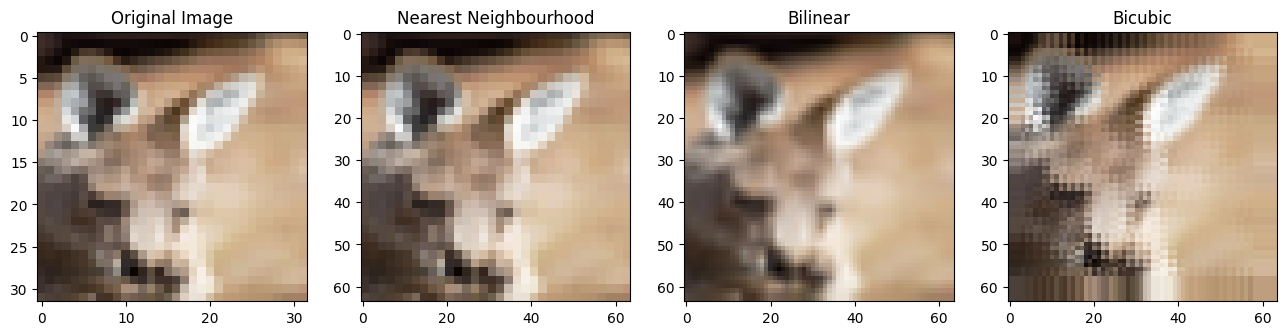

In [22]:
# Import packages
import numpy as np
import random
import cv2
import skimage.io
import matplotlib.pyplot as plt 

# Import some functions to the global namespace for convenience
from scipy.ndimage import *
from scipy.fft import *
from scipy.signal import * 
from scipy.stats import *
from skimage.filters import *
from keras.datasets import cifar100

def nearest_neighbour_interpolation(img, scale_percent):
    # Calculate the new dimensions
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)

    # Create an empty array to hold the resized image
    resized_img = np.zeros((height, width, 3), dtype=np.uint8)

    # Calculate the scaling factor for each dimension
    scale_x = img.shape[1] / resized_img.shape[1]
    scale_y = img.shape[0] / resized_img.shape[0]

    # Perform nearest neighbour interpolation
    for y in range(resized_img.shape[0]):
        for x in range(resized_img.shape[1]):
            src_x = int(x * scale_x)
            src_y = int(y * scale_y)
            resized_img[y, x] = img[src_y, src_x]

    return resized_img

def bilinear_interpolation(img, scale_percent):
    # Calculate the new dimensions
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)

    # Create an empty array to hold the resized image
    resized_img = np.zeros((height, width, 3), dtype=np.uint8)

    # Calculate the scaling factor for each dimension
    scale_x = img.shape[1] / resized_img.shape[1]
    scale_y = img.shape[0] / resized_img.shape[0]

    # Perform bilinear interpolation
    for y in range(height):
        for x in range(width):
             # Calculate the coordinates in the original image
            src_x = x * scale_x
            src_y = y * scale_y

            # Calculate the integer coordinates of the 4 nearest pixels
            x1 = int(np.floor(src_x))
            y1 = int(np.floor(src_y))
            x2 = min(x1 + 1, img.shape[1] - 1)
            y2 = min(y1 + 1, img.shape[0] - 1)

            # Calculate the fractional distances to the 4 nearest pixels
            tx = src_x - x1
            ty = src_y - y1

            # Calculate the pixel values of the 4 nearest pixels
            pixel1 = img[max(y1, 0), max(x1, 0)]
            pixel2 = img[max(y1, 0), min(x2, img.shape[1] - 1)]
            pixel3 = img[min(y2, img.shape[0] - 1), max(x1, 0)]
            pixel4 = img[min(y2, img.shape[0] - 1), min(x2, img.shape[1] - 1)]

            # Interpolate the pixel value using the fractional distances
            interpolated_pixel = (1 - tx) * (1 - ty) * pixel1 \
                + tx * (1 - ty) * pixel2 \
                + (1 - tx) * ty * pixel3 \
                + tx * ty * pixel4

            # Assign the interpolated pixel value to the resized image
            resized_img[y, x] = interpolated_pixel.astype(np.uint8)

    return resized_img

def cubic_interpolate(p, x):
    return p[1] + 0.5 * x*(p[2] - p[0] + x*(2.0*p[0] - 5.0*p[1] + 4.0*p[2] - p[3] + x*(3.0*(p[1] - p[2]) + p[3] - p[0])))

def bicubic_interpolate(img, x, y):
    x = np.clip(x, 1, img.shape[1]-3)  # Clip x indices within valid range
    y = np.clip(y, 1, img.shape[0]-3)  # Clip y indices within valid range
    
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    x2 = x0 + 2
    x3 = x0 + 3

    y0 = np.floor(y).astype(int)
    y1 = y0 + 1
    y2 = y0 + 2
    y3 = y0 + 3

    xp = np.clip([x0, x1, x2, x3], 0, img.shape[1]-1)  # Clip x indices within valid range
    yp = np.clip([y0, y1, y2, y3], 0, img.shape[0]-1)  # Clip y indices within valid range

    mat_l = np.empty((4, img.shape[2]), dtype=np.float64)
    mat_ll = np.empty((4, img.shape[2]), dtype=np.float64)
    mat_r = np.zeros(4, dtype=np.float64)
    
    # interpolate along x
    for i in range(4):
        for j in range(4):
            mat_l[j,:] = img[yp[j], xp[i], :]
        mat_ll[i,:] = cubic_interpolate(mat_l, x%1)

    return cubic_interpolate(mat_ll, y%1)

def bicubic_interpolation(img, scale):
    input_height, input_width, num_channels = img.shape
    output_height = int(input_height * scale)
    output_width = int(input_width * scale)

    output_img = np.empty((output_height, output_width, num_channels), dtype=np.uint8)

    row_ratio, col_ratio = input_height / output_height, input_width / output_width

    for row in range(output_height):
        for col in range(output_width):
            src_row = row * row_ratio # source row
            src_col = col * col_ratio # source column
            output_img[row, col, :] = bicubic_interpolate(img, src_col, src_row)

    return output_img
# Load CIFAR-10 dataset
(x_train, _), (_, _) = cifar100.load_data()

# Select a random image for interpolation
random_index = random.randint(0, len(x_train) - 1)
img = x_train[random_index]

# increase the size by 200%
scale_percent = 200                        

# Call the function to perform nearest neighbour interpolation
resized_img_nn = nearest_neighbour_interpolation(img, scale_percent)
resized_img_bn = bilinear_interpolation(img, scale_percent)
resized_img_bc = bicubic_interpolation(img, scale_percent/100)
plt.figure(figsize=(16,16))
plt.subplot(141),plt.imshow(img),plt.title('Original Image')
plt.subplot(142),plt.imshow(resized_img_nn),plt.title('Nearest Neighbourhood')
plt.subplot(143),plt.imshow(resized_img_bn),plt.title('Bilinear')
plt.subplot(144),plt.imshow(resized_img_bc),plt.title('Bicubic')
plt.show()